In [1]:
# univariate multi-step lstm
import os
import boto3
import json
import re
import kerastuner as kt
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
from kerastuner import Objective
from datetime import datetime
from math import sqrt
from numpy import (split, array)
from pandas import read_csv
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Flatten)

In [2]:
# define client, folder and files for AWS.
s3_client = boto3.client("s3")
s3_bucket_name = 'thesis-hydroponic-project'
s3_bucket_prefix = 'TemperatureAndHumidity2021/03'

In [3]:
# Fetch existing data or load fresh data.
# Remove redundancy and null.
#files = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_bucket_prefix)['Contents']
files = [{'Key': '/'.join(f.split('\\')[1:])} for f in glob.glob('.cache/**/**/**/***/*')]
parsed_sensor_values = []
for file in files:
    if False: #not os.path.isfile('.cache/' + file['Key']) or (datetime.now() - datetime.fromtimestamp(os.path.getctime('.cache/' + file['Key']))).days > 31:
        print("Fetching fresh file from S3:", file['Key'])
        if os.path.isfile('.cache/' + file['Key']):
            os.unlink('.cache/' + file['Key'])
        s3_object = s3_client.get_object(Bucket=s3_bucket_name, Key= file['Key'])
        raw_sensor_values = s3_object['Body'].read().decode()
        clean_sensor_values = re.sub(",+", ",", raw_sensor_values)
        sensor_values = json.loads("[" + clean_sensor_values.strip(',') + "]")
    else:
        print("Load from cache:", file['Key'])
        with open('.cache/' + file['Key']) as f:
            sensor_values = json.load(f)
    parsed_sensor_values += sensor_values
    os.makedirs('.cache/' + os.path.dirname(file['Key']), exist_ok=True)
    with open('.cache/' + file['Key'], 'w') as f:
        json.dump(sensor_values, f)

2d33c-944e-46de-8d37-28a6bf992123
Load from cache: TemperatureAndHumidity2021/03/29/02/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-02-55-47-7016dacb-4449-46ce-b8e7-1cbab7995d41
Load from cache: TemperatureAndHumidity2021/03/29/03/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-03-10-52-bb30d9e6-e9c3-4303-879e-362feecd838c
Load from cache: TemperatureAndHumidity2021/03/29/03/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-03-25-58-2209f8f2-fcb6-4653-bd0c-6856ad0429c0
Load from cache: TemperatureAndHumidity2021/03/29/03/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-03-41-06-1bb94952-fbe2-4851-a004-e3a4b2fef1ac
Load from cache: TemperatureAndHumidity2021/03/29/03/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-03-56-08-55391883-814a-44ed-899f-945b41f7138c
Load from cache: TemperatureAndHumidity2021/03/29/04/ThesisHydroponicSensorDeliveryStream-1-2021-03-29-04-11-14-d6528ed4-e4af-4d9f-9ec4-30cb3deda1c5
Load from cache: TemperatureAndHumidity2021/03/30/00/ThesisHydroponicSen

## Data preparation

In [4]:
df = pd.DataFrame(parsed_sensor_values)
df['temperature'] = df['temperature'].astype(float)
df['humidity'] = df['humidity'].astype(float)
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)

In [5]:
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (91774, 4)


,sensor_type,temperature,humidity,datetime
0,hydroponic sensor,14.0,38.0,2021-02-26 08:51:37
1,hydroponic sensor,15.0,36.0,2021-02-26 08:51:43
2,hydroponic sensor,15.0,36.0,2021-02-26 08:51:48
3,hydroponic sensor,15.0,36.0,2021-02-26 08:51:53
4,hydroponic sensor,15.0,35.0,2021-02-26 08:51:58


In [6]:
# resample data to hourly
hourly_groups = df.set_index('datetime').resample('1H')
# Calulating the mean will simply eliminate the data outliers
hourly_data = hourly_groups.mean()
hourly_data.dropna(inplace=True)
# summarize
print(hourly_data.shape)
print(hourly_data)
# save
hourly_data.to_csv('temperature_humidity_hourly.csv')

(775, 2)
                     temperature   humidity
datetime                                   
2021-02-26 08:00:00    20.978495  27.376344
2021-02-26 09:00:00    23.768421  24.040602
2021-02-26 10:00:00    25.008850  30.794690
2021-02-26 11:00:00    22.839286  31.142857
2021-02-26 12:00:00    23.854545  29.054545
...                          ...        ...
2021-03-31 06:00:00    24.000000  20.067039
2021-03-31 07:00:00    24.000000  20.352273
2021-03-31 08:00:00    24.331461  20.067416
2021-03-31 09:00:00    25.084746  20.084746
2021-03-31 10:00:00    25.666667  20.666667

[775 rows x 2 columns]


In [18]:
# split a univariate dataset into train/test sets
def split_dataset(data, interval_size):
    temp_a = int((len(data)*0.8)/interval_size)
    split_index = temp_a*interval_size
    temp_b = int(len(data)/interval_size)
    end_index = temp_b*interval_size
    # split into standard weeks(i.e. divisible by interval_size)
    train, test = data[:split_index], data[split_index:end_index]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/interval_size))
    test = array(split(test, len(test)/interval_size))
    return train, test

In [19]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [20]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [21]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [22]:
# train the model
def build_model(hp):
	# define hyperparameters parameters
	interval_size = hp.Int('interval_size', min_value=3, max_value=12, step=2)
	num_layers = hp.Int('num_layers', 1, 7, step=2, default=5)
	activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"], default="tanh")
	hiddent_units = hp.Choice('hiddent_units', [50, 100, 150, 200], default=200)
	
	# define model
	model = Sequential()
	# we want sigmoid in the first layer so that we convert the data between 0 and 1
	model.add(LSTM(hiddent_units, activation='sigmoid', input_shape=(interval_size, 1), return_sequences=num_layers > 1))
	for i in range(num_layers - 2):
		model.add(LSTM(hiddent_units, activation=activation, return_sequences=True, dropout=hp.Float("dropout", 0.0 , 0.8 , 0.2, default=0.4)))
	if num_layers > 1:
		model.add(LSTM(hiddent_units, activation=activation))
	model.add(Dense(interval_size))
	model.compile(loss='mse', optimizer='adam')
	return model

In [23]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [24]:
# evaluate a single model
def evaluate_model(train, test, n_input, model):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions

In [25]:
# load the new file
dataset = read_csv('temperature_humidity_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

def tuning_build_model(hp):
    interval_size = hp.Int('interval_size', min_value=3, max_value=12, step=2)
    return build_model(hp)

# We create our own tuning class to tune batch size, epochs, interval size, 
class MyTuner(kt.Tuner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def run_trial(self, trial, train_ds, **kwargs):
        hp = trial.hyperparameters
        batch_size = hp.Choice("batch_size", [0, 32, 64, 128, 256, 512], default=32)
        # When training with hyperparameters change the epoch size to 50 <------------------
        epochs = hp.Choice("epochs", [10])
        interval_size = hp.Int('interval_size', min_value=3, max_value=12, step=2)
        train, test = split_dataset(train_ds, interval_size)
        x,y=to_supervised(train, interval_size, interval_size)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        rmse_scores =  []
        for i in range(5):
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=False, callbacks=[callback])
            score, scores, predictions = evaluate_model(train, test, interval_size, model)
            rmse_scores.append(score)
        mean_rmse_score = sum(rmse_scores) / len(rmse_scores)
        variance_rmse_score = (sum([(mean_rmse_score-current_score)**2 for current_score in rmse_scores]))/len(rmse_scores)
        std_dev_rmse_score = sqrt(variance_rmse_score)
        self.oracle.update_trial(trial.trial_id, { 'score': mean_rmse_score, 'std': std_dev_rmse_score })

In [26]:
# When training with hyperparameters change the max_trails to min 72000 <------------------
tuner = MyTuner(
    oracle=kt.oracles.Hyperband(
          objective=kt.Objective('score', 'min'),
          max_epochs=50
    ),
    hypermodel=tuning_build_model,
    directory='forecasting_evaluation',
    project_name='lstm', overwrite=True
)
tuner.search_space_summary()
tuner.search(train_ds=dataset.values)
tuner.results_summary()

Search space summary
Default search space size: 5
interval_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 12, 'step': 2, 'sampling': None}
num_layers (Int)
{'default': 5, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 2, 'sampling': None}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
hiddent_units (Choice)
{'default': 200, 'conditions': [], 'values': [50, 100, 150, 200], 'ordered': True}
dropout (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': None}

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
interval_size     |7                 |?                 
num_layers        |5                 |?                 
activation        |tanh              |?                 
hiddent_units     |50                |?                 
dropout           |0.2               |?                 
tuner/epochs 

NameError: name 'tf' is not defined

In [27]:
# Print summary for same 
hyperparameter_results = defaultdict(list)
for file in glob.glob("forecasting_evaluation/lstm/trial*/trial.json"):
    trial = json.load(open(file))
    if trial['status'] == 'COMPLETED' and trial['score'] is not None:
        hyperparameter_results[str(trial["hyperparameters"]["values"])].append(trial["score"])

for param, rmse_scores in sorted(hyperparameter_results.items(), key=lambda a: sum(a[1])):
    mean_rmse_score = sum(rmse_scores)/len(rmse_scores)
    max_rmse_score = max(rmse_scores)
    min_rmse_score = min(rmse_scores)
    variance_rmse_score = (sum([(mean_rmse_score-current_score)**2 for current_score in rmse_scores]))/len(rmse_scores)
    std_dev_rmse_score = sqrt(variance_rmse_score)
    # summarize scores
    print("-----------------------------------------")
    print("hyperparameter tune",param)
    print("mean_rmse_score",mean_rmse_score)
    print("max_rmse_score",max_rmse_score)
    print("min_rmse_score",min_rmse_score)
    print("variance_rmse_score",variance_rmse_score)
    print("std_dev_rmse_score",std_dev_rmse_score)
    break

In [28]:
## Kör det här!!!  

import tensorflow as tf
# load the new file
dataset = read_csv('temperature_humidity_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
interval_size_rmse_list = []
interval_size_std_rmse_list = []

interval_size_list = list(range(3, 12, 2))
for interval_size in interval_size_list:
    print("--------------------------------------")
    print("interval_size",interval_size)
    train, test = split_dataset(dataset.values, interval_size)
    # evaluate model and get scores
    n_input = interval_size
    # mean, maximum,minimum,std_dev,
    rmse_scores = []
    train_x, train_y = to_supervised(train, n_input, n_input)
    for i in range(10):
        hp = kt.HyperParameters()
        hp.Int('interval_size', min_value=3, max_value=12, step=2, default=interval_size)
        model = build_model(hp)
        epochs = 10
        batch_size = 32

        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=False, callbacks=[callback])
        score, scores, predictions = evaluate_model(train, test, interval_size, model)
        rmse_scores.append(score)
    
    # Prepare and calculate results
    mean_rmse_score = sum(rmse_scores)/len(rmse_scores)
    max_rmse_score = max(rmse_scores)
    min_rmse_score = min(rmse_scores)
    variance_rmse_score = (sum([(mean_rmse_score-current_score)**2 for current_score in rmse_scores]))/len(rmse_scores)
    std_dev_rmse_score = sqrt(variance_rmse_score)
    # Add values to list
    interval_size_rmse_list.append(mean_rmse_score)
    interval_size_std_rmse_list.append(std_dev_rmse_score)
    # summarize scores
    print("mean_rmse_score",mean_rmse_score)
    print("max_rmse_score",max_rmse_score)
    print("min_rmse_score",min_rmse_score)
    print("variance_rmse_score",variance_rmse_score)
    print("std_dev_rmse_score",std_dev_rmse_score)
    # summarize_scores('lstm', mean_score, scores)

--------------------------------------
interval_size 3
mean_rmse_score 0.590010325053946
max_rmse_score 0.5914330364341694
min_rmse_score 0.5879220743362378
variance_rmse_score 1.479713481869562e-06
std_dev_rmse_score 0.0012164347421335688
--------------------------------------
interval_size 5
mean_rmse_score 0.6137647981286704
max_rmse_score 0.6208375052333752
min_rmse_score 0.6109501245855792
variance_rmse_score 7.53048508096808e-06
std_dev_rmse_score 0.002744172932044932
--------------------------------------
interval_size 7
mean_rmse_score 0.6052062625022241
max_rmse_score 0.6160023086790744
min_rmse_score 0.5941961084201051
variance_rmse_score 4.8962000011658334e-05
std_dev_rmse_score 0.006997285188675558
--------------------------------------
interval_size 9
mean_rmse_score 0.628621203983198
max_rmse_score 0.6783657303037914
min_rmse_score 0.6085378495914296
variance_rmse_score 0.0003726790225533918
std_dev_rmse_score 0.01930489633625086
--------------------------------------
int

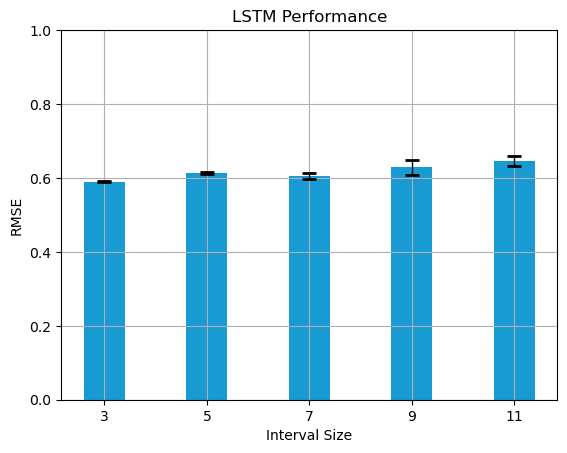

In [30]:
# plot scores
pyplot.rcdefaults()
fig, ax = pyplot.subplots()
ax.bar(interval_size_list, interval_size_rmse_list, yerr=interval_size_std_rmse_list, align='center', color='#189ad3', label='lstm', error_kw=dict(ecolor="black", lw=1, capsize=5, capthick=2))
ax.set_xticks(interval_size_list)
ax.set_ylabel('RMSE')
ax.set_xlabel('Interval Size')
ax.set_title('LSTM Performance')
pyplot.rc('lines')
pyplot.grid(True)
pyplot.ylim([0, 1])
pyplot.savefig('forecast_lstm_result.png', bbox_inches='tight')
pyplot.show()

In [31]:
df_test = pd.DataFrame(test.reshape(test.shape[0]* test.shape[1], 2), columns=["temperature","humidity"])
df_pred = pd.DataFrame(predictions.reshape(predictions.shape[0]* predictions.shape[1],),columns=["pred_temperature"])
predicted_and_test = df_pred.join(df_test)
predicted_and_test.to_csv('predicted_temperature_and_test_values.csv',index=False)